This notebook analyses the technical and opportunity lags of workflow files w.r.t. reusable actions. It requires the "lag.csv.xz" dataset (in the `data`) folder, generated by the `Compute technical lag` notebook. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn
import lifelines

In [2]:
FIG_SIZE = (7, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-09-30')

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SEED = 12345
SAVEFIG = True

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

## Load data

In [3]:
df_lag = (
    pd.read_csv(
        '../data/lag.csv.xz',
        parse_dates=['snapshot', 'selected_date', 'first_missed_date', 'last_missed_date'],
    )
    .assign(outdated=lambda d: ~d.first_missed.isnull())
    .assign(tlag=lambda d: d.last_missed_date - d.selected_date)
    .assign(olag=lambda d: d.snapshot - d.first_missed_date)
)

In [4]:
df_lag.sample(n=5, random_state=SEED)

,repository,snapshot,workflow,job,step,action,anchor,selected,selected_date,first_missed,first_missed_date,last_missed,last_missed_date,outdated,tlag,olag
979230,joseexposito/touchegg,2021-05-01,ef7d3ce98397555dbe4685105baa7c708589da2331dd43...,rpm-package,3,actions/checkout,v2,v2.3.4,2020-11-03 14:48:49,NaN,NaT,NaN,NaT,False,NaT,NaT
83065,pinojs/sonic-boom,2022-08-01,994e14a82f526ca27d831d97549ad9a218cca48882c55d...,test,1,actions/checkout,v3,v3.0.2,2022-04-21 14:56:58,NaN,NaT,NaN,NaT,False,NaT,NaT
417221,ben-manes/caffeine,2022-03-01,3c21005f3afc5e609dfe35f4325165633efa6769533d7f...,lincheck,1,actions/checkout,v2.4.0,v2.4.0,2021-11-02 17:48:06,NaN,NaT,NaN,NaT,False,NaT,NaT
2260771,lest/prometheus-rpm,2022-09-01,9373da1350f6d57368448c5d2de490a01ff8fff3495c14...,build_packages,2,actions/setup-python,v2,v2.3.2,2022-02-04 11:10:37,v3.0.0,2022-02-28 10:30:59,v4.2.0,2022-08-02 12:44:58,True,179 days 01:34:21,184 days 13:29:01
203529,gimli-rs/addr2line,2022-07-01,4058a78ee6e31c8639e673133ab222e0c0534e2eb26f5e...,msrv,1,actions/checkout,v2,v2.4.2,2022-04-21 16:04:02,v3.0.0,2022-03-01 17:48:27,v3.0.2,2022-04-21 14:56:58,True,-1 days +22:52:56,121 days 06:11:33


In [5]:
print(len(df_lag.drop_duplicates('repository')), 'repositories')
print(len(df_lag.drop_duplicates('action')), 'distinct actions')
print(len(df_lag.drop_duplicates(['repository', 'workflow'])), 'workflows (through time)')
print(len(df_lag.drop_duplicates(['snapshot', 'repository', 'workflow', 'job', 'step'])), 'steps (through time)')

22462 repositories
2320 distinct actions
206453 workflows (through time)
3422135 steps (through time)


## Outdated steps

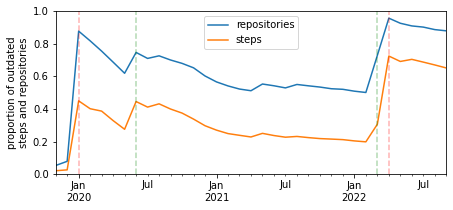

In [6]:
fig, ax = matplotlib.pyplot.subplots()

temp = pd.concat([
    df_lag
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        steps=('step', 'count'), 
        outdated=('outdated', 'sum'),
    )
    .assign(steps=lambda d: d.outdated / d.steps)
    [['steps']]
    ,
    df_lag
    .groupby([pd.Grouper(key='snapshot', freq='M'), 'repository'])
    .agg({'outdated': 'max'})
    .reset_index()
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        repositories=('repository', 'nunique'),
        outdated=('outdated', 'sum'),
    )
    .assign(repositories=lambda d: d.outdated / d.repositories)
    [['repositories']]
], axis=1)

temp[['repositories', 'steps']].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of outdated\nsteps and repositories', 
    ylim=(0, 1),
)

# Look at "releases.csv.gz" for the exact dates! (those "coded" have one extra month)
# actions/checkout v2
ax.vlines(pd.to_datetime('2020-01'), 0, 1, colors='r', alpha=0.3, linestyles='dashed')

# actions/setup-python, setup-node, setup-java, setup-go, etc. v2
ax.vlines(pd.to_datetime('2020-06'), 0, 1, colors='g', alpha=0.3, linestyles='dashed')

# actions/setup-python, setup-node, setup-java, setup-go, etc. v3
ax.vlines(pd.to_datetime('2022-03'), 0, 1, colors='g', alpha=0.3, linestyles='dashed')

# actions/checkout v3
ax.vlines(pd.to_datetime('2022-04'), 0, 1, colors='r', alpha=0.3, linestyles='dashed')


savefig(fig, 'lag_outdated')

In [7]:
print(temp.describe().T.to_string())
display(temp.iloc[-1])

              count      mean       std       min       25%       50%       75%       max
steps          35.0  0.349367  0.184687  0.021240  0.227575  0.297250  0.421494  0.724556
repositories   35.0  0.638288  0.203626  0.053407  0.531778  0.618912  0.750718  0.956794


steps           0.651522
repositories    0.879118
Name: 2022-09-30 00:00:00, dtype: float64

### Actions provided by GitHub

It seems that most of what can be observed (including for technical and opportunity lags below) is due to the Actions provided by GitHub (those starting with `actions/`). This is not surprising since they correspond to the most widely used Actions in GitHub Actions workflows. Let's quantify their usage:

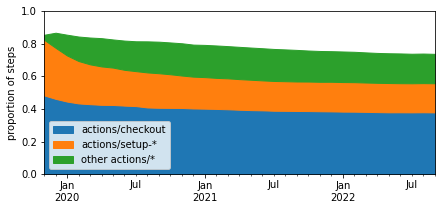

In [8]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    .assign(checkout=lambda d: d.action == 'actions/checkout')
    .assign(setup=lambda d: d.action.str.startswith('actions/setup-'))
    .assign(other=lambda d: d.action.str.startswith('actions/'))
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        checkout=('checkout', 'sum'),
        setup=('setup', 'sum'),
        other=('other', 'sum'),
        steps=('step', 'count'),
    )
    .assign(other=lambda d: d.other - d.setup - d.checkout)
    .assign(remaining=lambda d: d.steps - d.other - d.setup - d.checkout)
    .apply(lambda s: s / s.steps, axis=1)
)

(
    temp
    [['checkout', 'setup', 'other']]
    .rename(columns={'checkout': 'actions/checkout', 'setup': 'actions/setup-*', 'other': 'other actions/*'})
    .plot(ax=ax, kind='area', style=' ', stacked=True, color=PALETTE)
)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of steps',
    ylim=(0, 1),
)

savefig(fig, 'lag_prop_steps_github')

In [9]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
checkout,35.0,0.403036,0.024990,0.379063,0.384511,0.395315,0.413393,0.483432
setup,35.0,0.205692,0.039766,0.178256,0.180825,0.187652,0.214516,0.340980
other,35.0,0.178171,0.033419,0.030586,0.180786,0.187478,0.195769,0.198824
steps,35.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
remaining,35.0,0.213101,0.038849,0.132465,0.185129,0.219078,0.246539,0.261998


checkout     0.379063
setup        0.178474
other        0.180465
steps        1.000000
remaining    0.261998
Name: 2022-09-30 00:00:00, dtype: float64

Without those Actions provided by GitHub, the situation looks a bit different (but still...): 

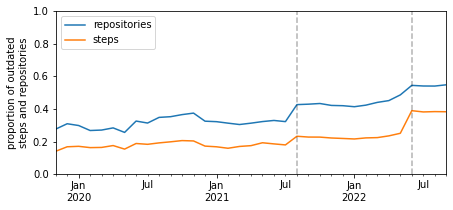

In [10]:
fig, ax = matplotlib.pyplot.subplots()

temp = pd.concat([
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        steps=('step', 'count'), 
        outdated=('outdated', 'sum'),
    )
    .assign(steps=lambda d: d.outdated / d.steps)
    [['steps']]
    ,
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    .groupby([pd.Grouper(key='snapshot', freq='M'), 'repository'])
    .agg({'outdated': 'max'})
    .reset_index()
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        repositories=('repository', 'nunique'),
        outdated=('outdated', 'sum'),
    )
    .assign(repositories=lambda d: d.outdated / d.repositories)
    [['repositories']]
], axis=1)

temp[['repositories', 'steps']].plot(ax=ax, color=PALETTE)
ax.legend(loc='upper left')

ax.vlines(pd.to_datetime('2021-08'), 0, 18, colors='k', alpha=0.3, linestyles='dashed')
ax.vlines(pd.to_datetime('2022-06'), 0, 18, colors='k', alpha=0.3, linestyles='dashed')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of outdated\nsteps and repositories', 
    ylim=(0, 1),
)

savefig(fig, 'lag_outdated_wo_actions')

The peaks that can be observed in July 2021 and April 2022 are due to:

 - For August 2021, `codecov/codecov-action` was updated to 2.0.0 (going from 193 to 1,606 outdated steps)
 - For June 2022, various `docker/*` Actions were updated (build-push-action v3.0.0, login-action v2.0.0, setup-buildx-action v2.0.0, setup-qemu-action v2.0.0), going from 285 to 6,344 outdated steps.

In [11]:
print(temp.describe().T.to_string())
display(temp.iloc[-1])

              count      mean       std       min       25%       50%      75%       max
steps          35.0  0.215066  0.067261  0.140625  0.171640  0.192792  0.22590  0.389496
repositories   35.0  0.374769  0.085901  0.256287  0.312999  0.348327  0.42802  0.548257


steps           0.382915
repositories    0.548257
Name: 2022-09-30 00:00:00, dtype: float64

## Technical lag

### For steps

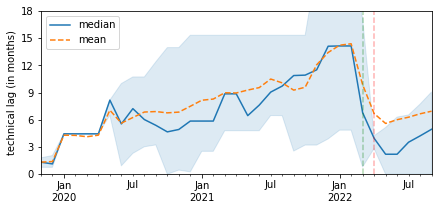

In [12]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    # Only outdated actions are considered
    [lambda d: d.outdated]
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        mean=('tlag', 'mean'),
        median=('tlag', 'median'),
        p25=('tlag', lambda s: s.quantile(0.25)),
        p75=('tlag', lambda s: s.quantile(0.75)),
    )
    .pipe(lambda d: d / pd.to_timedelta('30 day'))
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')


# actions/setup-python, setup-node, setup-java, setup-go, etc. v3
ax.vlines(pd.to_datetime('2022-03'), 0, 18, colors='g', alpha=0.3, linestyles='dashed')

# actions/checkout v3
ax.vlines(pd.to_datetime('2022-04'), 0, 18, colors='r', alpha=0.3, linestyles='dashed')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='technical lag (in months)',
    ylim=(0, 18),
)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3))

savefig(fig, 'lag_technical_steps')

In march 2022 (when `actions/checkout` and the various `actions/setup-X` got a `v3` release), the proportion of outdated steps increased (as seen in a previous figure). One may expect the technical lag to increase at the same time. That's not the case, mostly because at the same time `v3` was released, a patch for `v2` was released as well, therefore lowering the technical lag for those relying on `v2`. 

In [13]:
print(temp.describe().T.to_string())
display(temp.iloc[-1])

        count       mean       std       min       25%        50%        75%        max
mean     35.0   7.673986  3.082353  1.332806  6.137120   6.952969   9.421674  14.397150
median   35.0   6.690547  3.483128  1.135127  4.455687   5.865027   8.871037  14.155698
p25      35.0   2.841399  2.122790 -0.001552  0.758678   3.027038   4.627135   6.507971
p75      35.0  11.998487  6.233621  1.803554  6.420456  13.972304  15.335855  24.331526


mean      6.952969
median    4.959369
p25      -0.001552
p75       9.069656
Name: 2022-09-30 00:00:00, dtype: float64

### Without Actions provided by GitHub

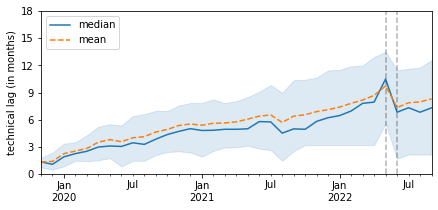

In [14]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    # Only outdated actions are considered
    [lambda d: d.outdated]
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        mean=('tlag', 'mean'),
        median=('tlag', 'median'),
        p25=('tlag', lambda s: s.quantile(0.25)),
        p75=('tlag', lambda s: s.quantile(0.75)),
    )
    .pipe(lambda d: d / pd.to_timedelta('30 day'))
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')

ax.vlines(pd.to_datetime('2022-05'), 0, 18, colors='k', alpha=0.3, linestyles='dashed')
ax.vlines(pd.to_datetime('2022-06'), 0, 18, colors='k', alpha=0.3, linestyles='dashed')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='technical lag (in months)',
    ylim=(0, 18),
)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3))


savefig(fig, 'lag_technical_steps_wo_actions')

In [15]:
print(temp.describe().T.to_string())
display(temp.iloc[-1])

        count      mean       std       min       25%       50%        75%        max
mean     35.0  5.647286  2.111037  1.340869  4.082943  5.710548   7.242732   9.751952
median   35.0  4.969656  2.060849  1.090530  3.379704  4.959369   6.353268  10.512045
p25      35.0  2.316839  0.993551  0.505223  1.514556  2.401390   3.046205   5.612896
p75      35.0  8.415428  3.170345  1.803554  6.521232  8.255444  11.461005  13.500517


mean       8.316907
median     7.326921
p25        2.162706
p75       12.600600
Name: 2022-09-30 00:00:00, dtype: float64

### For repositories

We aggregate lag at repository level by taking the maximal value of its steps.

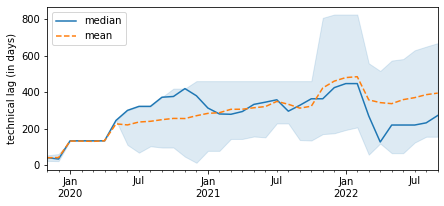

In [16]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    # Only outdated actions are considered
    [lambda d: d.outdated]
    .groupby(['snapshot', 'repository'], as_index=False, sort=False)
    .agg({'tlag': 'max'})
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        mean=('tlag', 'mean'),
        median=('tlag', 'median'),
        p25=('tlag', lambda s: s.quantile(0.25)),
        p75=('tlag', lambda s: s.quantile(0.75)),
    )
    .pipe(lambda d: d / pd.to_timedelta('1 day'))
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='technical lag (in days)',
)

savefig(fig, 'lag_technical_repos')

In [17]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
mean,35.0,288.563042,109.993903,41.403846,238.498380,306.477263,353.370301,484.263900
median,35.0,279.423532,108.330598,34.053808,220.069919,295.704734,360.883380,446.593819
p25,35.0,124.092793,58.703554,13.596505,78.763264,133.670602,155.987002,245.296088
p75,35.0,444.602966,211.917164,54.106632,322.061748,460.075648,565.045995,824.200150


### Without Actions provided by GitHub

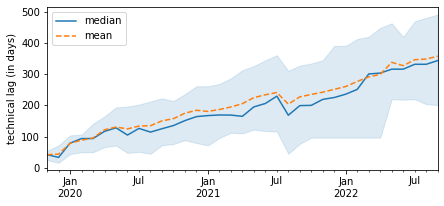

In [18]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    # Only outdated actions are considered
    [lambda d: d.outdated]
    .groupby(['snapshot', 'repository'], as_index=False, sort=False)
    .agg({'tlag': 'max'})
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        mean=('tlag', 'mean'),
        median=('tlag', 'median'),
        p25=('tlag', lambda s: s.quantile(0.25)),
        p75=('tlag', lambda s: s.quantile(0.75)),
    )
    .pipe(lambda d: d / pd.to_timedelta('1 day'))
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='technical lag (in days)',
)

savefig(fig, 'lag_technical_repos_wo_actions')

## Opportunity lag

### For steps

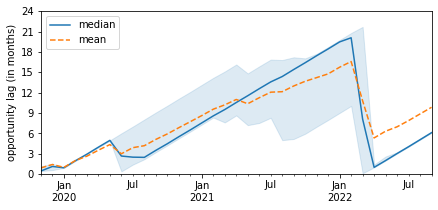

In [19]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    # Only outdated actions are considered
    [lambda d: d.outdated]
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        mean=('olag', 'mean'),
        median=('olag', 'median'),
        p25=('olag', lambda s: s.quantile(0.25)),
        p75=('olag', lambda s: s.quantile(0.75)),
    )
    .pipe(lambda d: d / pd.to_timedelta('30 day'))
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='opportunity lag (in months)',
    ylim=(0, 24),
)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3))


savefig(fig, 'lag_opportunity_steps')

The large decrease in opportunity lag in March 2022 is due the increase in the number of outdated steps. Indeed, all the steps that relied on `v2` started to have a lag when `v3` was released, but this lag is quite low since the first missed version was recently released.

In [20]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
mean,35.0,8.054495,4.453774,0.931858,4.278096,7.887461,11.124781,16.582881
median,35.0,7.686376,5.990024,0.472824,2.809568,5.514364,12.064364,20.077920
p25,35.0,4.728390,2.890403,0.139791,2.106754,5.012334,7.261973,10.052370
p75,35.0,10.279396,6.666528,0.945014,4.096280,10.078347,16.472560,21.681031


Let's have a look at the selected major train for `actions/checkout` and `actions/setup-X`: 

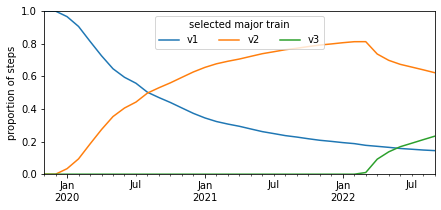

In [21]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    #[lambda d: d.outdated]
    [lambda d: (d.action == 'actions/checkout') | (d.action.str.startswith('actions/setup-'))]
    .assign(
        selected_major=lambda d: np.where(d.selected.str.startswith('v1'), 'v1', 
                                    np.where(d.selected.str.startswith('v2'), 'v2',
                                        np.where(d.selected.str.startswith('v3'), 'v3', 'other')
                                    )
                                )
    )
    .groupby([pd.Grouper(key='snapshot', freq='M'), 'selected_major'])
    .agg(steps=('step', 'count'))
    .unstack()
    .fillna(0)
    ['steps']
)

temp[['v1', 'v2', 'v3']].apply(lambda d: d / d.sum(), axis=1).plot(ax=ax)
ax.legend(title='selected major train', ncol=3, loc='upper center')
ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of steps', 
    ylim=(0, 1),
)

savefig(fig, 'lag_switch_v1_v2_v3')

### Without Actions provided by GitHub

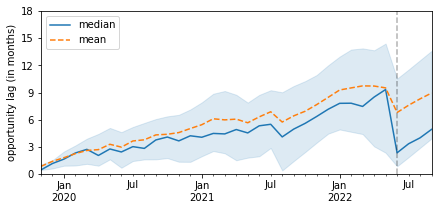

In [22]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    # Only outdated actions are considered
    [lambda d: d.outdated]
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        mean=('olag', 'mean'),
        median=('olag', 'median'),
        p25=('olag', lambda s: s.quantile(0.25)),
        p75=('olag', lambda s: s.quantile(0.75)),
    )
    .pipe(lambda d: d / pd.to_timedelta('30 day'))
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')

ax.vlines(pd.to_datetime('2022-06'), 0, 18, colors='k', alpha=0.3, linestyles='dashed')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='opportunity lag (in months)',
    ylim=(0, 18),
)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3))


savefig(fig, 'lag_opportunity_steps_wo_actions')

In [23]:
print(temp.describe().T.to_string())
display(temp.iloc[-1])

        count      mean       std       min       25%       50%        75%        max
mean     35.0  5.749199  2.578596  0.865279  3.731998  5.996679   7.645449   9.747334
median   35.0  4.419569  2.123858  0.472824  2.816431  4.114955   5.425424   9.346578
p25      35.0  2.089741  1.246903  0.413151  1.254701  1.779409   2.728177   4.937309
p75      35.0  8.374588  3.781522  1.061992  5.432860  8.764122  11.245659  14.416173


mean       8.959326
median     4.946813
p25        3.942927
p75       13.613151
Name: 2022-09-30 00:00:00, dtype: float64

### For repositories

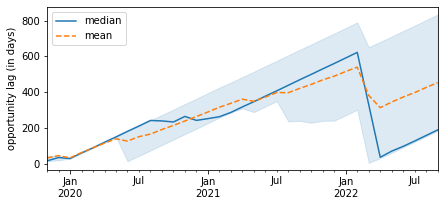

In [24]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    # Only outdated actions are considered
    [lambda d: d.outdated]
    .groupby(['snapshot', 'repository'], as_index=False, sort=False)
    .agg({'olag': 'max'})
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        mean=('olag', 'mean'),
        median=('olag', 'median'),
        p25=('olag', lambda s: s.quantile(0.25)),
        p75=('olag', lambda s: s.quantile(0.75)),
    )
    .pipe(lambda d: d / pd.to_timedelta('1 day'))
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='opportunity lag (in days)',
)

savefig(fig, 'lag_opportunity_repos')

In [25]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
mean,35.0,292.676248,149.848555,31.417713,157.896175,337.450995,397.578883,539.854686
median,35.0,259.076004,172.659004,15.192512,122.896395,241.350417,361.930926,622.430926
p25,35.0,161.199033,104.707696,4.426400,66.844473,152.258021,239.775156,349.557500
p75,35.0,454.667095,263.108816,28.350417,225.850417,484.350417,689.890671,834.430926


### Without Actions provided by GitHub

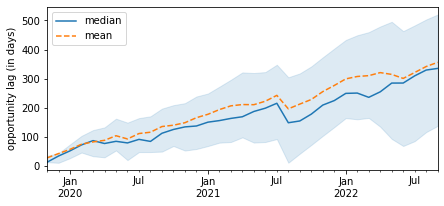

In [26]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    # Only outdated actions are considered
    [lambda d: d.outdated]
    .groupby(['snapshot', 'repository'], as_index=False, sort=False)
    .agg({'olag': 'max'})
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        mean=('olag', 'mean'),
        median=('olag', 'median'),
        p25=('olag', lambda s: s.quantile(0.25)),
        p75=('olag', lambda s: s.quantile(0.75)),
    )
    .pipe(lambda d: d / pd.to_timedelta('1 day'))
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='opportunity lag (in days)',
)

savefig(fig, 'lag_opportunity_repos_wo_actions')

In [27]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
mean,35.0,197.751157,94.842447,28.991794,114.702755,207.361938,288.470619,356.489664
median,35.0,168.712963,85.647399,14.184711,90.294965,156.811887,230.957598,335.661458
p25,35.0,76.268863,43.564176,12.161976,48.086604,69.773681,96.708067,165.998449
p75,35.0,291.272482,143.080808,35.986372,168.367154,305.197118,418.325208,520.349097


## Correlation between lags

In [28]:
display(
    df_lag
    [lambda d: d.outdated]
    .assign(tlag=lambda d: d.tlag.dt.days, olag=lambda d: d.olag.dt.days)
    [['tlag', 'olag']]
    .corr(method='pearson')
)
display(
    df_lag
    [lambda d: d.outdated]
    .assign(tlag=lambda d: d.tlag.dt.days, olag=lambda d: d.olag.dt.days)
    [['tlag', 'olag']]
    .corr(method='spearman')
)

,tlag,olag
tlag,1.000000,0.759424
olag,0.759424,1.000000


,tlag,olag
tlag,1.000000,0.622731
olag,0.622731,1.000000


Data points (steps) are not independant since we have the evolution of their lags through time. 
Let's compute the correlations for each snapshot. 

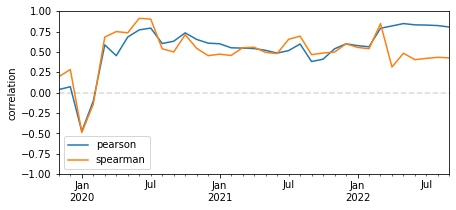

In [29]:
fig, ax = matplotlib.pyplot.subplots()

temp = pd.concat([
    df_lag
    [lambda d: d.outdated]
    .assign(tlag=lambda d: d.tlag.dt.days, olag=lambda d: d.olag.dt.days)
    .groupby(pd.Grouper(key='snapshot', freq='M'))    
    .apply(lambda g: g[['tlag', 'olag']].corr(method='pearson').loc['olag'][['tlag']])
    .rename(columns={'tlag': 'pearson'})
    ,
    df_lag
    [lambda d: d.outdated]
    .assign(tlag=lambda d: d.tlag.dt.days, olag=lambda d: d.olag.dt.days)
    .groupby(pd.Grouper(key='snapshot', freq='M'))    
    .apply(lambda g: g[['tlag', 'olag']].corr(method='spearman').loc['olag'][['tlag']])
    .rename(columns={'tlag': 'spearman'})
], axis=1)

temp.plot(ax=ax, color=PALETTE)
ax.legend(title=None)
ax.hlines(0, DATE_RANGE[0], DATE_RANGE[1], color='k', linestyle='--', alpha=0.15)
ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='correlation',
    ylim=(-1, 1),
)

savefig(fig, 'lag_correlation_evolution')

In [30]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
olag,,,,,,,,
pearson,35.0,0.548832,0.283617,-0.475062,0.517292,0.596489,0.75173,0.847219
spearman,35.0,0.497223,0.261577,-0.488938,0.443590,0.497861,0.62640,0.912024


We remove Actions provided by GitHub to avoid biaising the analysis.

In [31]:
display(
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    [lambda d: d.outdated]
    .assign(tlag=lambda d: d.tlag.dt.days, olag=lambda d: d.olag.dt.days)
    [['tlag', 'olag']]
    .corr(method='pearson')
)
display(
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    [lambda d: d.outdated]
    .assign(tlag=lambda d: d.tlag.dt.days, olag=lambda d: d.olag.dt.days)
    [['tlag', 'olag']]
    .corr(method='spearman')
)

,tlag,olag
tlag,1.000000,0.378901
olag,0.378901,1.000000


,tlag,olag
tlag,1.000000,0.472875
olag,0.472875,1.000000


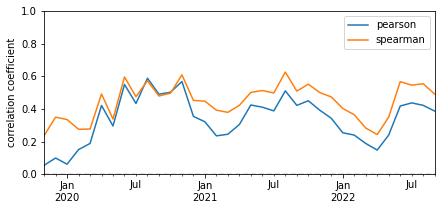

In [32]:
fig, ax = matplotlib.pyplot.subplots()

temp = pd.concat([
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    [lambda d: d.outdated]
    .assign(tlag=lambda d: d.tlag.dt.days, olag=lambda d: d.olag.dt.days)
    .groupby(pd.Grouper(key='snapshot', freq='M'))    
    .apply(lambda g: g[['tlag', 'olag']].corr(method='pearson').loc['olag'][['tlag']])
    .rename(columns={'tlag': 'pearson'})
    ,
    df_lag
    [lambda d: ~d.action.str.startswith('actions/')]
    [lambda d: d.outdated]
    .assign(tlag=lambda d: d.tlag.dt.days, olag=lambda d: d.olag.dt.days)
    .groupby(pd.Grouper(key='snapshot', freq='M'))    
    .apply(lambda g: g[['tlag', 'olag']].corr(method='spearman').loc['olag'][['tlag']])
    .rename(columns={'tlag': 'spearman'})
], axis=1)

temp.plot(ax=ax, color=PALETTE)
ax.legend(title=None)
ax.hlines(0, DATE_RANGE[0], DATE_RANGE[1], color='k', linestyle='--', alpha=0.15)
ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='correlation coefficient',
    ylim=(0, 1),
)

savefig(fig, 'lag_correlation_evolution_wo_actions')

In [33]:
print(temp.describe().T.to_string())
display(temp.iloc[-1])

          count      mean       std       min       25%       50%       75%       max
olag                                                                                 
pearson    35.0  0.341230  0.143426  0.054376  0.240088  0.387166  0.429038  0.588685
spearman   35.0  0.445905  0.108540  0.236074  0.357656  0.475294  0.511356  0.626171


olag
pearson     0.387166
spearman    0.491162
Name: 2022-09-30 00:00:00, dtype: float64

### Scatter plot

Since data points are not independant (a same repository/step has its evolution in our dataframe), let's consider a single snapshot.
We also remove Actions provided by GitHub to avoid biaising the analysis.

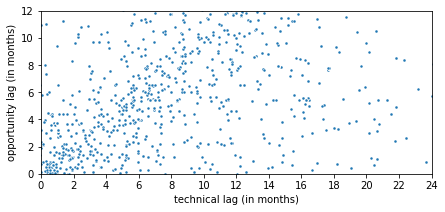

In [34]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    [lambda d: d.snapshot == d.snapshot.max()]
    [lambda d: d.outdated]
    [lambda d: ~d.action.str.startswith('actions/')]
    #.sample(frac=0.5, random_state=SEED)
    .assign(tlag=lambda d: d.tlag.dt.days / 30, olag=lambda d: d.olag.dt.days / 30)
    [['tlag', 'olag']]
)

seaborn.scatterplot(
    x='tlag',
    y='olag',
    data=temp,
    marker='.',
    ax=ax,
    rasterized=True,
)

ax.set(
    xlabel='technical lag (in months)',
    xlim=(0, 24),
    ylabel='opportunity lag (in months)', 
    ylim=(0, 12),
)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))

savefig(fig, 'lag_correlation_snapshot_wo_actions')

Same, but with another visualisation:

/tmp/ipykernel_92307/3920205867.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([(x - 1) * 2 for x in range(x)])
/tmp/ipykernel_92307/3920205867.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([(x - 1) * 2 for x in range(y)])


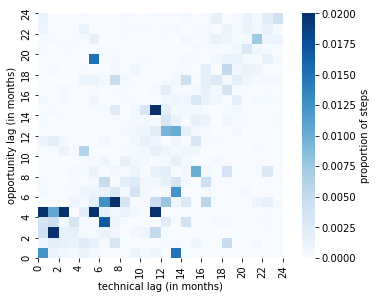

In [94]:
fig, ax = matplotlib.pyplot.subplots()

fig.set_size_inches(FIG_SIZE[0], FIG_SIZE[1] * 1.5)
x, y = 24, 24

seaborn.heatmap(
    vmin=0,
    vmax=0.02,
    cmap='Blues',
    square=True,
    data=(
        temp
        .round(0).astype(int)
        .assign(steps=1)
        .groupby(['tlag', 'olag'])
        .count()
        .assign(steps=lambda d: d.steps / d.steps.sum())
        .unstack(level=1)
        ['steps']
        .fillna(0)
        .loc[range(0, x)][range(0, y)]
        .T
    ),
    cbar_kws={'label': 'proportion of steps'},
    ax=ax,
)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.set_xticklabels([(x - 1) * 2 for x in range(x)])

ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.set_yticklabels([(x - 1) * 2 for x in range(y)])

ax.set(
    xlabel='technical lag (in months)',
    xlim=(0, x),
    ylabel='opportunity lag (in months)', 
    ylim=(0, y),
)

savefig(fig, 'lag_correlation_snapshot_wo_actions-heatmap')

Another attempt to show the spread of values: 

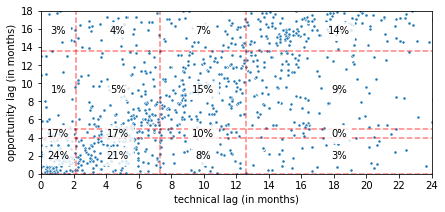

In [35]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_lag
    [lambda d: d.snapshot == d.snapshot.max()]
    [lambda d: d.outdated]
    [lambda d: ~d.action.str.startswith('actions/')]
    #.sample(frac=0.5, random_state=SEED)
    .assign(tlag=lambda d: d.tlag.dt.days / 30, olag=lambda d: d.olag.dt.days / 30)
    [['tlag', 'olag']]
)

seaborn.scatterplot(
    x='tlag',
    y='olag',
    data=temp,
    marker='.',
    ax=ax,
    rasterized=True,
)

# Percentiles
quantile = temp.quantile([0, 0.25, 0.5, 0.75, 1])
for i in range(len(quantile) - 1):
    ax.vlines(quantile.iloc[i].tlag, 0, 18, linestyles='dashed', color='r', alpha=0.5)
    ax.hlines(quantile.iloc[i].olag, 0, 24, linestyles='dashed', color='r', alpha=0.5)
    
    for j in range(len(quantile) - 1):
        steps = (
            temp
            [lambda d: d.tlag.between(quantile.iloc[i].tlag, quantile.iloc[i + 1].tlag)]
            [lambda d: d.olag.between(quantile.iloc[j].olag, quantile.iloc[j + 1].olag)]
        )
        
        ax.text(
            max(0, quantile.iloc[i].tlag) + (min(24, quantile.iloc[i + 1].tlag) - max(0, quantile.iloc[i].tlag)) / 2,
            max(0, quantile.iloc[j].olag) + (min(18, quantile.iloc[j + 1].olag) - max(0, quantile.iloc[j].olag)) / 2,
            '{:.0%}'.format(len(steps) / len(temp)),
            ha='center',
            va='center',
            backgroundcolor=(1, 1, 1, 0.8),
        )
        
ax.set(
    xlabel='technical lag (in months)',
    xlim=(0, 24),
    ylabel='opportunity lag (in months)', 
    ylim=(0, 18),
)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))


### A few examples

Manually selected ones, to show all combinations of low/high technical/opportunity lags. 

In [36]:
(
    df_lag
    [lambda d: d.outdated]
    [lambda d: d.snapshot == '2022-09-01']
    [lambda d: d.tlag.dt.days >= 200]
    [lambda d: d.olag.dt.days <= 10]
    [lambda d: d.anchor == 'v1.2.1']
)

,repository,snapshot,workflow,job,step,action,anchor,selected,selected_date,first_missed,first_missed_date,last_missed,last_missed_date,outdated,tlag,olag
3167051,jenkinsci/warnings-ng-plugin,2022-09-01,cb105a31cba18c91cdc4b5f8f7f03dcab0a72c918893a9...,add-reviews,1,kentaro-m/auto-assign-action,v1.2.1,v1.2.1,2021-11-20 14:14:50,v1.2.2,2022-08-29 12:02:30,v1.2.3,2022-08-30 14:43:33,True,283 days 00:28:43,2 days 11:57:30
3167052,firebase/firebase-js-sdk,2022-09-01,16394c33f2476fe07b202ae639299ab4e01f4d1ae566c7...,check_doc_changes,7,kentaro-m/auto-assign-action,v1.2.1,v1.2.1,2021-11-20 14:14:50,v1.2.2,2022-08-29 12:02:30,v1.2.3,2022-08-30 14:43:33,True,283 days 00:28:43,2 days 11:57:30
3167053,gradle/gradle,2022-09-01,15a7334cde5395c462d9941818d3df2b496485c9b14ee4...,add-reviews,1,kentaro-m/auto-assign-action,v1.2.1,v1.2.1,2021-11-20 14:14:50,v1.2.2,2022-08-29 12:02:30,v1.2.3,2022-08-30 14:43:33,True,283 days 00:28:43,2 days 11:57:30
3170728,schemacrawler/schemacrawler,2022-09-01,56a5f6bfb7fd6e4db2a84be63dc09143fba273c91813ae...,build,1,sualeh/prepare-maven-build,v1.2.1,v1.2.1,2022-01-14 21:36:11,v1.3.0,2022-08-31 19:10:19,v1.3.1,2022-08-31 19:19:31,True,228 days 21:43:20,0 days 04:49:41
3170729,schemacrawler/schemacrawler,2022-09-01,c2900ba63e224a2bfb5bb81c13b0d3c1701c55812ed785...,build,1,sualeh/prepare-maven-build,v1.2.1,v1.2.1,2022-01-14 21:36:11,v1.3.0,2022-08-31 19:10:19,v1.3.1,2022-08-31 19:19:31,True,228 days 21:43:20,0 days 04:49:41
3170730,schemacrawler/schemacrawler,2022-09-01,fa1d93bb79c93306608799c3f6033dc368f8f8e0a95a8b...,build,1,sualeh/prepare-maven-build,v1.2.1,v1.2.1,2022-01-14 21:36:11,v1.3.0,2022-08-31 19:10:19,v1.3.1,2022-08-31 19:19:31,True,228 days 21:43:20,0 days 04:49:41
3170731,schemacrawler/schemacrawler,2022-09-01,c116ce8f6fd21b41ba206c21986448273e83f2c17e579e...,build,1,sualeh/prepare-maven-build,v1.2.1,v1.2.1,2022-01-14 21:36:11,v1.3.0,2022-08-31 19:10:19,v1.3.1,2022-08-31 19:19:31,True,228 days 21:43:20,0 days 04:49:41


In [37]:
temp = (
    df_lag
    [lambda d: d.outdated]
    .assign(tlag=lambda d: d.tlag.dt.days, olag=lambda d: d.olag.dt.days)
    .assign(delta=lambda d: d.last_missed_date - d.first_missed_date)
    .sort_values('delta', ascending=False)
    .drop_duplicates(['repository', 'snapshot', 'action'])
    .drop(columns=['workflow', 'job', 'step', 'outdated', 'delta'])
    .query('tlag > 0 and first_missed != last_missed and selected_date < first_missed_date')
)

pd.concat([
    temp.query('tlag < 20 and olag > 200').iloc[0],
    temp.query('tlag < 20 and olag < 20').iloc[0],
    temp.query('tlag > 200 and olag < 20').iloc[1],
    temp.query('tlag > 200 and olag > 200').iloc[1],
    ], axis=1
).T

,repository,snapshot,action,anchor,selected,selected_date,first_missed,first_missed_date,last_missed,last_missed_date,tlag,olag
3244292,flank/flank,2021-09-01,unlyed/github-action-store-variable,v2.1.0,v2.1.0,2021-02-04 16:20:26,v2.1.1,2021-02-04 16:26:21,v2.1.2,2021-02-19 09:45:48,14,208
3395577,yargs/cliui,2020-11-01,bcoe/release-please-action,v2.5.5,v2.5.5,2020-10-10 00:58:52,v2.5.6,2020-10-15 01:16:58,v2.5.7,2020-10-30 00:01:32,19,16
2045506,agersant/polaris,2020-08-01,actions/download-artifact,v1,v1.0.0,2019-08-01 13:03:32,v2.0.1,2020-07-15 10:38:25,v2.0.3,2020-07-31 17:26:43,365,16
2059391,le5le-com/topology,2022-09-01,actions/setup-node,v1.1.0,v1.1.0,2019-08-06 22:32:41,v1.1.1,2019-08-13 20:32:48,v3.4.1,2022-07-14 10:48:29,1072,1114
